In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import binom

### Main variables initialization

In [2]:
#coach variables
coach_L = 300    # low price of coach
coach_H = 350    # high price of coach 
coach_L_prob = [0.65,0.35] # demand probabilities for low price on coach
coach_H_prob= [0.30,0.70] # demand probabilities for high price on coach
coach_seats=100    # number of coach seats
coach_show=0.95 # probability of coach seat passenger showing up

# first class variables
first_L = 425    # low price of first
first_H = 500    # high price of first
first_L_prob = [0.08,0.92] # demand probabilities for low price on first class
first_H_prob = [0.04,0.96] # demand probabilities for high price on first class
first_seats=20        # number of first class seats
first_show=0.97   # probability of first seat passenger showing up

# general variables
discount = 1/(1+0.15/365) # discount rate
T=365 #365 days in a year
first_bump_cost = -50    # cost if coach passenger is bumped to first class
plane_bump_cost = -425   # cost if the overbooked passenger is bumped of the plane

In [3]:
def DP_solve(no_selling,overbook):    
    coach_Values = np.arange(coach_seats+overbook+1)  # all possible number of coach seats left
    first_Values = np.arange(first_seats+1)  # all possible number first class  of seats left
    tValues = np.arange(T+1)                 # all possible days until takeoff
    num_coach=len(coach_Values)  # number of coach seats
    num_first=len(first_Values)  # number of first class seats
    tN=len(tValues)
  
    V = np.zeros((num_coach,num_first,tN))   # initialize value function
    U = np.zeros((num_coach,num_first,tN)) # initialize optimal choice variable
    
    # boundary/terminal condition
    U[:,:,tN-1] = 0  # 0 is the value for no tickets for sale
    
    # filling the all possible values of coach and first class seats with expected cost at time tN( at time of departure)
    for coach_sold in range(num_coach):
        for first_sold in range(num_first): 
            revenue = 0 
            for i in range(coach_sold+1): 
                for j in range(first_sold+1):
                    if i > coach_seats:
                        prob = binom.pmf(i, coach_sold, coach_show) * binom.pmf(j, first_sold, first_show)
                        num_plane_bump = max(i-coach_seats,0) 
                        num_first_bump= min(first_seats-j,num_plane_bump)
                        temp = (first_bump_cost*num_first_bump + (num_plane_bump-num_first_bump)*plane_bump_cost)
                        revenue += temp*prob

            V[coach_sold, first_sold , tN-1] = revenue
            
            
            
    for t in reversed(range(tN-1)): 
        for i in range(num_coach):  
            for j in range(num_first): 

                # all are sold out
                if (i == num_coach-1) and (j == num_first-1):
                    V[i, j, t] = discount * V[i, j, t+1]
                    U[i, j, t] = 0 

                    #coach is sold out and first class is available
                elif (i == num_coach-1) and (j < num_first-1): 
                    V_CH_FH = first_H * first_H_prob[0] + discount*(first_H_prob[0]*V[i, j+1, t+1] + first_H_prob[1]*V[i, j, t+1])
                    V_CH_FL = first_L * first_L_prob[0] + discount*(first_L_prob[0]*V[i, j+1, t+1] + first_L_prob[1]*V[i, j, t+1])
                    V_CL_FH = V_CH_FH
                    V_CL_FL = V_CH_FL
                    V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                    U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 
                    
                    #first class is sold out and coach class is available

                elif (i < num_coach-1) and (j == num_first-1): 
                    V_CH_FH = coach_H * coach_H_prob[0] + discount*(coach_H_prob[0]*V[i+1, j, t+1] + coach_H_prob[1]*V[i, j, t+1])
                    V_CL_FH = coach_L * coach_L_prob[0] + discount*(coach_L_prob[0]*V[i+1, j, t+1] + coach_L_prob[1]*V[i, j, t+1])
                    V_CH_FL = V_CH_FH
                    V_CL_FL = V_CL_FH
                    
                    if no_selling:
                        V_N_FH = discount*(coach_H_prob[0] * V[i, j, t+1] + coach_H_prob[1] * V[i, j, t+1])
                        V_N_FL = discount*(coach_L_prob[0] * V[i, j, t+1] + coach_L_prob[1] * V[i, j, t+1])        
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH , V_N_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH , V_N_FL])+1 
                    else:
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 
                        

                    
                    # coach and first class seats  are available
                else: 
                    V_CH_FH = (coach_H + first_H) * first_H_prob[0] * coach_H_prob[0] + \
                    coach_H * coach_H_prob[0] * first_H_prob[1] + first_H * first_H_prob[0] * coach_H_prob[1] + \
                    discount*(coach_H_prob[0] * first_H_prob[0] * V[i+1, j+1, t+1] + coach_H_prob[0] * first_H_prob[1]*V[i+1, j, t+1] + \
                              coach_H_prob[1] * first_H_prob[0]*V[i, j+1, t+1] + coach_H_prob[1] * first_H_prob[1]*V[i, j, t+1])


                    V_CH_FL =  (coach_H + first_L) * coach_H_prob[0] * first_L_prob[0] + coach_H * coach_H_prob[0] * first_L_prob[1] + \
                    first_L * first_L_prob[0] * coach_H_prob[1] + discount*(coach_H_prob[0] * first_L_prob[0] * V[i+1, j+1, t+1] + \
                              coach_H_prob[0] * first_L_prob[1]*V[i+1, j, t+1] + coach_H_prob[1] * first_L_prob[0]*V[i, j+1, t+1] + \
                              coach_H_prob[1] * first_L_prob[1]*V[i, j, t+1])


                    V_CL_FH =  (coach_L + first_H) * coach_L_prob[0] * first_H_prob[0] + \
                    coach_L * coach_L_prob[0] * first_H_prob[1] + first_H * first_H_prob[0] * coach_L_prob[1] + \
                    discount*(coach_L_prob[0] * first_H_prob[0] * V[i+1, j+1, t+1] + coach_L_prob[0] * first_H_prob[1]*V[i+1, j, t+1] + \
                              coach_L_prob[1] * first_H_prob[0]*V[i, j+1, t+1] + coach_L_prob[1] * first_H_prob[1]*V[i, j, t+1])


                    V_CL_FL =  (coach_L + first_L) * coach_L_prob[0] * first_L_prob[0] + \
                    coach_L * coach_L_prob[0] * first_L_prob[1] +  first_L * first_L_prob[0] * coach_L_prob[1] + \
                    discount*(coach_L_prob[0] * first_L_prob[0] * V[i+1, j+1, t+1] +  coach_L_prob[0] * first_L_prob[1]*V[i+1, j, t+1] + \
                              coach_L_prob[1] * first_L_prob[0]*V[i, j+1, t+1] + coach_L_prob[1] * first_L_prob[1]*V[i, j, t+1])

                    # IF NO SALE IS AN OPTION
                    if no_selling:
                        V_N_FH = first_H * first_H_prob[0] + discount*(first_H_prob[0] * V[i, j+1, t+1] + first_H_prob[1]*V[i, j, t+1])
                        V_N_FL = first_L * first_L_prob[0] + discount*(first_L_prob[0] * V[i, j+1, t+1] + first_L_prob[1]*V[i, j, t+1])

                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH, V_N_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL, V_N_FH, V_N_FL])+1 
                    else: 
                        V[i, j, t] = max(V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL)
                        U[i, j, t] = np.argmax([V_CH_FH, V_CH_FL, V_CL_FH, V_CL_FL])+1 

                    
    return V, U

    

### Q1

In [18]:
V, U = DP_solve(False,5)
print('The expected profit with 5 over booking is $',V[0,0,0])

The expected profit with 5 over booking is $ 42242.86219879507


### Q2

In [5]:
overbooking = np.arange(5,16)
exp_profit = []
for i in overbooking:
  V, U = DP_solve(False,i)
  exp_profit.append(V[0,0,0])
  print('The expected profit with ',i,' over booking is $', V[0,0,0])

The expected profit with  5  over booking is $ 42242.86219879507
The expected profit with  6  over booking is $ 42368.86899301223
The expected profit with  7  over booking is $ 42444.241213317226
The expected profit with  8  over booking is $ 42482.211237591255
The expected profit with  9  over booking is $ 42496.112304378694
The expected profit with  10  over booking is $ 42495.97195739831
The expected profit with  11  over booking is $ 42488.25953578203
The expected profit with  12  over booking is $ 42476.99620870186
The expected profit with  13  over booking is $ 42464.59794015476
The expected profit with  14  over booking is $ 42452.36220993062
The expected profit with  15  over booking is $ 42440.944844238955


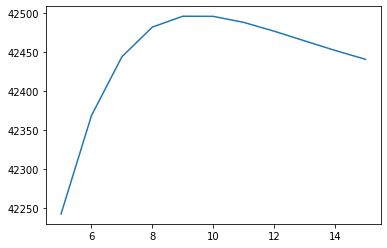

In [6]:
plt.plot(overbooking, exp_profit)

The highest expected profit is when number of over bookings is at 9

### Q3

In [7]:
V, U = DP_solve(True,20)
print('The expected profit with 20 over booking is $',V[0,0,0])

The expected profit with 20 over booking is $ 42502.67326124377


The expected profit with no sale option and 20 over booking is more than the expected profit with 9 overbookings. The latter strategy seems to perform better

### Q4

In [8]:
def DP_forward_simulations(U, overbook):
  
    coach_Values = np.arange(coach_seats+overbook+1) # all possible number of coach seats left
    first_Values = np.arange(first_seats+1)  # all possible number of first class seats left
    tValues = np.arange(T+1)  # all possible days until take off
    num_coach=len(coach_Values) 
    num_first=len(first_Values) 
    tN=len(tValues)
    revenue,c,f=[0,0,0]
    

    for t in range(tN-1):
        # getting the optimum price decision at time t
        price_opt = U[c, f, t] 
        
        coach_prob,coach_price,first_prob,first_price=[0,0,0,0]
        
        # setting coach and first prices based on the optimum price decision
        if (price_opt==1) |(price_opt==2):
            coach_prob = coach_H_prob[0]
            coach_price = coach_H

        if (price_opt==3) |(price_opt==4):
            coach_prob = coach_L_prob[0]
            coach_price = coach_L

        if (price_opt==1) |(price_opt==3):
            first_prob = first_H_prob[0]
            first_price = first_H

        if (price_opt==4) |(price_opt==2):
            first_prob = first_L_prob[0]
            first_price = first_L

        if price_opt == 5: 
            first_prob = first_H_prob[1]
            first_price = first_H

        if price_opt == 6:
            coach_prob = first_L_prob[1]
            first_prob = first_L


        if c == num_coach - 1:
            coach_prob = 0
        if f == num_first - 1:
            first_prob = 0

        coach_sale = (np.random.random(1) < coach_prob) 
        first_sale = (np.random.random(1) < first_prob) 
        revenue += (coach_sale*coach_price + first_sale*first_price) * discount**t
        c += coach_sale
        f += first_sale
        

     # number of people showed up 
    coach_showup = np.random.binomial(c, coach_show)
    first_showup = np.random.binomial(f, first_show)
    
    oversold = max(coach_showup-coach_seats,0) 
    first_bump = min(first_seats-first_showup,oversold)

    profit = revenue
    num_overbook = max(0, c - coach_seats)
    cost_overbook = (first_bump_cost*first_bump + (oversold-first_bump)*plane_bump_cost)
    bump_out_plane = max(oversold-first_bump, 0)

    return profit, num_overbook, cost_overbook, bump_out_plane

    


In [9]:
nsim = 1000
profit_fpolicy = np.zeros(nsim) 
num_overbook_fpolicy = np.zeros(nsim) 
cost_overbook_fpolicy = np.zeros(nsim) 
bump_out_plane_fpolicy = np.zeros(nsim)
profit_spolicy = np.zeros(nsim) 
num_overbook_spolicy = np.zeros(nsim) 
cost_overbook_spolicy = np.zeros(nsim) 
bump_out_plane_spolicy = np.zeros(nsim)

# getting optimal value fucntion and decision at the best value of 9 over bookings and No sale option with 20 overbookings
V, U_fpolicy = DP_solve(False,9)
V, U_spolicy = DP_solve(True,20)

for i in range(nsim):
    profit_fpolicy[i], num_overbook_fpolicy[i], cost_overbook_fpolicy[i], bump_out_plane_fpolicy[i] = DP_forward_simulations(U_fpolicy,9)
    profit_spolicy[i], num_overbook_spolicy[i], cost_overbook_spolicy[i], bump_out_plane_spolicy[i] = DP_forward_simulations(U_spolicy,20)

In [10]:
## over booking

print("The percentage of overbooking in the first policy is  " ,(num_overbook_fpolicy > 0).sum()/len(num_overbook_fpolicy) * 100,' %')
## over booking

print("The percentage of overbooking in the second policy is  " ,(num_overbook_spolicy > 0).sum()/len(num_overbook_spolicy) * 100,' %')

The percentage of overbooking in the first policy is   100.0  %
The percentage of overbooking in the second policy is   100.0  %


In both the policies, the passengers are overbooked in each time

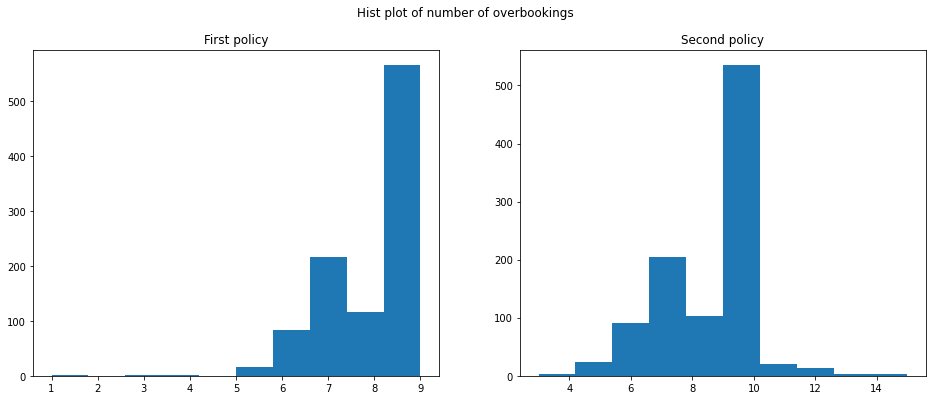

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of number of overbookings')
ax1.hist(num_overbook_fpolicy)
ax1.set_title('First policy')
ax2.hist(num_overbook_spolicy)
ax2.set_title('Second policy')
fig.show()

In [12]:
## bumped off yhe plane
print("The percentage of times passengers kicked off the plane in the first policy is  " ,(bump_out_plane_fpolicy > 0).sum()/len(bump_out_plane_fpolicy) * 100,' %')
print("The percentage of times passengers kicked off the plane in the second policy is  " ,(bump_out_plane_spolicy > 0).sum()/len(bump_out_plane_spolicy) * 100,' %')

The percentage of times passengers kicked off the plane in the first policy is   70.6  %
The percentage of times passengers kicked off the plane in the second policy is   72.1  %


Passengers are kicked off the plabe less often in the first policy

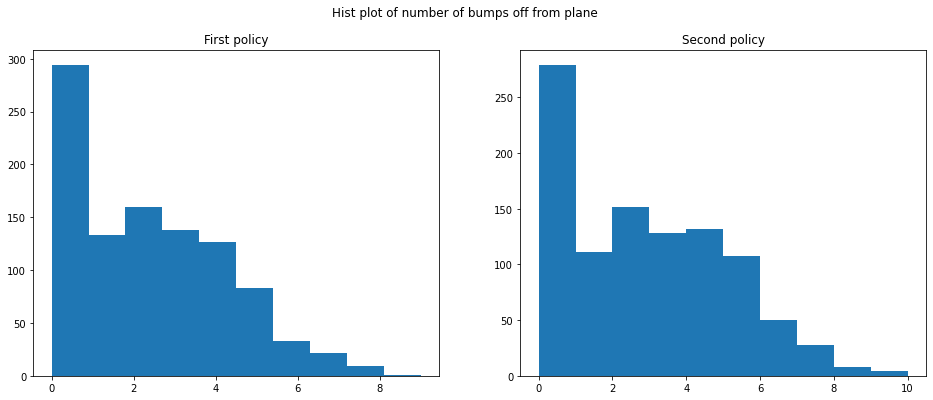

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of number of bumps off from plane')
ax1.hist(bump_out_plane_fpolicy)
ax1.set_title('First policy')
ax2.hist(bump_out_plane_spolicy)
ax2.set_title('Second policy')
fig.show()

In [14]:
##avg_overbooking_cost
avg_overbooking_cost_fpolicy = (profit_fpolicy + cost_overbook_fpolicy).mean()
avg_overbooking_cost_spolicy = (profit_spolicy + cost_overbook_spolicy).mean()
print('Average over booking cost of first policy is  $',avg_overbooking_cost_fpolicy )
print('Average over booking cost of second policy is  $',avg_overbooking_cost_spolicy )

Average over booking cost of first policy is  $ 42314.80454405685
Average over booking cost of second policy is  $ 42281.18265520048


 Average over booking cost is less in the second policy

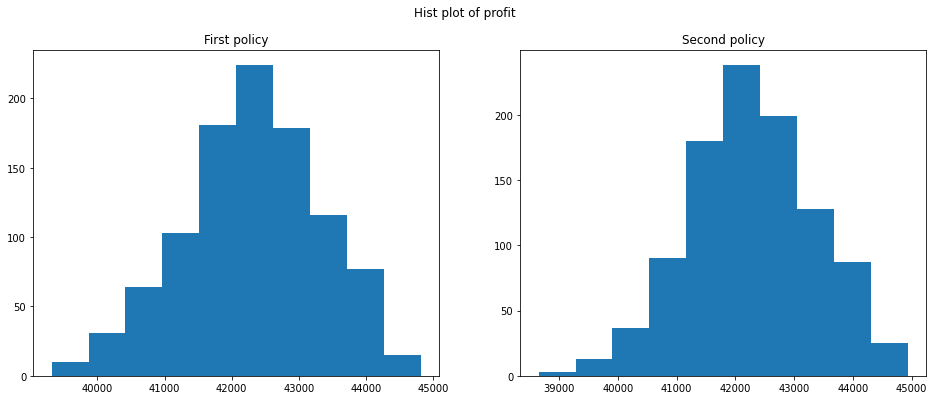

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of profit')
ax1.hist(profit_fpolicy + cost_overbook_fpolicy)
ax1.set_title('First policy')
ax2.hist(profit_spolicy + cost_overbook_spolicy)
ax2.set_title('Second policy')
fig.show()

In [16]:
##volatility
volatility_fpolicy = (profit_fpolicy ).std()
volatility_spolicy = (profit_spolicy ).std()
print('volatility of first policy is  $',volatility_fpolicy )
print('volatility of second policy is  $',volatility_spolicy )

volatility of first policy is  $ 876.5812865888706
volatility of second policy is  $ 932.980923218409


volatility is higher in the second policy

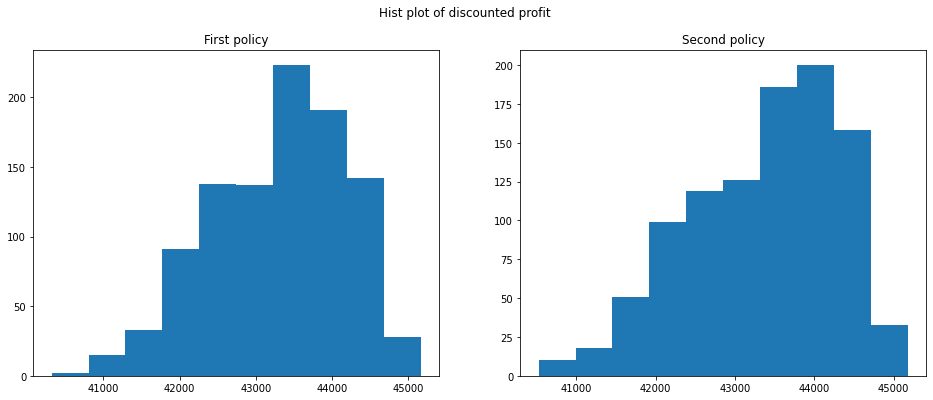

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Hist plot of discounted profit')
ax1.hist(profit_fpolicy )
ax1.set_title('First policy')
ax2.hist(profit_spolicy )
ax2.set_title('Second policy')
fig.show()